## This script loads 0.10 deg MSWEP and computes statistics

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."  

path2Create = r'C:/rezaul/academic/research/project/PIRE/prcp/output/'

if not os.path.exists(path2Create):
    os.makedirs(path2Create)    
    
path2Save = 'C:/rezaul/academic/research/project/PIRE/prcp/output/fig/'

if not os.path.exists(path2Save):
    os.makedirs(path2Save)    

IMAGES_PATH = os.path.join(path2Save)
outputPath = os.path.join(path2Save)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
yrStMswep = 1991   # User choice    
yrEndMswep = 2021    # Decided to include 30 years plus the validation year

nYrsMswep = yrEndMswep - yrStMswep + 1
print(nYrsMswep)

monStMswep =1                # January
monEndMswep = 12             # December
nMonsMswep = monEndMswep - monStMswep + 1
print(nMonsMswep)

nSites = 4                 # Four sites of Dangistha, Gaita, Kudmi, and Reem for "PIRE" Project-work
nIdTot = 2                 # = two (JJAS and Yrly Total)

jjasMonSt = 6              # Starts at June (JJAS)
jjasMonEnd = 9             # Ends in September (JJAS)
nJjasMons = jjasMonEnd - jjasMonSt + 1
print(nJjasMons)


31
12
4


In [3]:
yr2019Id = 2019 - yrStMswep + 1  
print(yr2019Id)
yr2020Id = 2020 - yrStMswep + 1  
print(yr2020Id)

29
30


## Import Libraries

In [4]:
# Common imports
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
#from osgeo import gdal # Import the GDAL library
#import gdal

import cmocean

#import matplotlib.pyplot as plt # Import the Matplotlib package
from matplotlib import pyplot as plt  # Import the Matplotlib package
from numpy import linspace # Import the Linspace numpy library
from numpy import meshgrid # Import the Meshgrid numpy library

#from init import *
import scipy.io as sio
# Common imports
import calendar
import datetime
import matplotlib.dates as mdates
from numpy import array, ma
#import scipy.io
from scipy.io import loadmat   # https://scipy-cookbook.readthedocs.io/items/Reading_mat_files.html
import xarray as xr


In [5]:
# Stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gamma, norm
from scipy.signal import detrend

from netCDF4 import Dataset   # http://code.google.com/p/netcdf4-python/
from numpy.random import normal
from numpy import hstack

import math


In [6]:
# Plotting
import matplotlib.colors as colors
from copy import copy
import matplotlib.cm as cm
#from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
import matplotlib.gridspec as gridspec


In [7]:
# Projection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [8]:
#file = C:/rezaul/academic/1.research/project/HRRR/data/dnld/20210101/countyShapeFiles/countyl010g.shp
import cartopy.io.shapereader as shpreader
reader = shpreader.Reader('C:/rezaul/1.academic/1.research/1.data/shapeFile/countyShapeFiles/countyl010g.shp')

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

In [9]:
# General info:
#monTarget = 6  # Target is June 
# Edit this for the month desired ===============
#monStr = str(calendar.month_name[monTarget])
#print(monStr)

# Boundary
extent = [34, 40, 6, 14]
print(extent)

[34, 40, 6, 14]


## Metadata of CFSv2 forecast to pick the number of grid cells in the study area

In [10]:
#   C:/rezaul/academic/research/project/PIRE/seasonalFcst/data/regrid10DegCfsv2GtifShiftMat/precip/2019/201904/M01/precipFcstRegridLatLon.mat
memStr = 'M01'
matFileF = loadmat(r'C:/rezaul/1.academic/1.research/2.project/PIRE/seasonalFcst/data/regrid10DegCfsv2GtifShiftMat/precip/2020/202004/M01/precipFcstRegridLatLon.mat')

matFileF.keys()

dict_keys(['__header__', '__version__', '__globals__', 'lat', 'lon', 'precipFcstRegrid'])

In [11]:
print(matFileF['precipFcstRegrid'].shape)
nlat, nlon, ntim = matFileF['precipFcstRegrid'].shape
time = np.arange(ntim)
print(time.shape)

(82, 61, 856)
(856,)


In [12]:
latsCfs = matFileF['lat']
print(latsCfs.shape)
print(latsCfs[0:5])
print(latsCfs[-1])

(82, 1)
[[14.05]
 [13.95]
 [13.85]
 [13.75]
 [13.65]]
[5.95]


In [13]:
lonsCfs = matFileF['lon']
print(lonsCfs.shape)
print(lonsCfs[0:5])
print(lonsCfs[-1])

(61, 1)
[[33.95]
 [34.05]
 [34.15]
 [34.25]
 [34.35]]
[39.95]


## Metadata for MSWEP

In [14]:
ncFile = r'C:/rezaul/1.academic/1.research/1.data/MSWEP/V280/monthly/197906.nc'

ncFile

'C:/rezaul/1.academic/1.research/1.data/MSWEP/V280/monthly/197906.nc'

In [15]:
nc_fid = Dataset(ncFile, 'r')
nc_fid

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    history: Created on 2021-02-04 03:43
    dimensions(sizes): lon(3600), lat(1800), time(1)
    variables(dimensions): float32 lon(lon), float32 lat(lat), int32 time(time), float32 precipitation(time, lat, lon)
    groups: 

In [16]:
ds1 = xr.open_dataset(ncFile)
ds1

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 1)
Coordinates:
  * lon            (lon) float32 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time           (time) datetime64[ns] 1979-06-01
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes:
    history:  Created on 2021-02-04 03:43

In [17]:
latsMswep = nc_fid.variables['lat'][:]
lonsMswep = nc_fid.variables['lon'][:]

print(latsMswep.shape)
print(lonsMswep.shape)

prcpMswep = nc_fid.variables['precipitation'][:]
print(prcpMswep.shape)

(1800,)
(3600,)
(1, 1800, 3600)


In [18]:
# Cropping for Ethiopia
# By looking into the meta-data, the following ID numbers were selected to represent the study area of the Blue Nile Basin

iiCellMswepSt = 759           
iiCellMswepEnd = 840

jjCellMswepSt = 2139
jjCellMswepEnd = 2199

print(latsMswep[iiCellMswepSt])
print(latsMswep[iiCellMswepEnd])

print(lonsMswep[jjCellMswepSt])
print(lonsMswep[jjCellMswepEnd])


14.049998
5.95
33.95001
39.95001


In [19]:
# Dangistha ID:
iiCellMswepGlobalLoc = 788;
jjCellMswepGlobalLoc = 2169;

print(latsMswep[iiCellMswepGlobalLoc-1])
print(lonsMswep[jjCellMswepGlobalLoc-1])

11.249995
36.850002


In [20]:
latsMswepEth = latsMswep[iiCellMswepSt:iiCellMswepEnd+1]
latsMswepEth

masked_array(data=[14.049998 , 13.95     , 13.850001 , 13.749995 ,
                   13.649997 , 13.549998 , 13.45     , 13.350001 ,
                   13.249995 , 13.149997 , 13.049998 , 12.95     ,
                   12.850001 , 12.749995 , 12.649997 , 12.549998 ,
                   12.45     , 12.350001 , 12.249995 , 12.149997 ,
                   12.049998 , 11.95     , 11.850001 , 11.749995 ,
                   11.649997 , 11.549998 , 11.45     , 11.350001 ,
                   11.249995 , 11.149997 , 11.049998 , 10.95     ,
                   10.850001 , 10.749995 , 10.649997 , 10.549998 ,
                   10.45     , 10.350001 , 10.249995 , 10.149997 ,
                   10.049998 ,  9.95     ,  9.850001 ,  9.749995 ,
                    9.649997 ,  9.549998 ,  9.45     ,  9.350001 ,
                    9.249995 ,  9.149997 ,  9.049998 ,  8.95     ,
                    8.850001 ,  8.749995 ,  8.649997 ,  8.549998 ,
                    8.45     ,  8.350001 ,  8.249995 ,  8.1499

In [21]:
lonsMswepEth = lonsMswep[jjCellMswepSt:jjCellMswepEnd+1]
lonsMswepEth

masked_array(data=[33.95001 , 34.05    , 34.150005, 34.249996, 34.350002,
                   34.45001 , 34.55    , 34.650005, 34.749996, 34.850002,
                   34.95001 , 35.05    , 35.150005, 35.249996, 35.350002,
                   35.45001 , 35.55    , 35.650005, 35.749996, 35.850002,
                   35.95001 , 36.05    , 36.150005, 36.249996, 36.350002,
                   36.45001 , 36.55    , 36.650005, 36.749996, 36.850002,
                   36.95001 , 37.05    , 37.150005, 37.249996, 37.350002,
                   37.45001 , 37.55    , 37.650005, 37.749996, 37.850002,
                   37.95001 , 38.05    , 38.150005, 38.249996, 38.350002,
                   38.45001 , 38.55    , 38.650005, 38.749996, 38.850002,
                   38.95001 , 39.05    , 39.150005, 39.249996, 39.350002,
                   39.45001 , 39.55    , 39.650005, 39.749996, 39.850002,
                   39.95001 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [22]:

# Following are the IDs wihtin the Domain of the BNB (not the Global)

# Dangistha
print('Dangistha')
iiCellDanMswep = 29;
jjCellDanMswep = 30;
print(latsMswepEth[iiCellDanMswep-1])
print(lonsMswepEth[jjCellDanMswep-1])
print('')
#++++++++++

print('Gaita')
iiCellGaitaMswep = 30
jjCellGaitaMswep = 30  
print(latsMswepEth[iiCellGaitaMswep-1])
print(lonsMswepEth[jjCellGaitaMswep-1])
print('')
#++++++++++

print('Kudmi')
iiCellKudmiMswep = 28
jjCellKudmiMswep = 32  
print(latsMswepEth[iiCellKudmiMswep-1])
print(lonsMswepEth[jjCellKudmiMswep-1])
print('')
#++++++++++

print('Reem')
iiCellReemMswep = 28
jjCellReemMswep = 33  
print(latsMswepEth[iiCellReemMswep-1])
print(lonsMswepEth[jjCellReemMswep-1])
#++++++++++


Dangistha
11.249995
36.850002

Gaita
11.149997
36.850002

Kudmi
11.350001
37.05

Reem
11.350001
37.150005


In [23]:
#STOP

## Extract 30 years of MSWEP data as 3hrly Value, get monthly for this exercise

In [24]:

mswepCellsMonTotYrs = np.zeros((nlat,nlon, nYrsMswep, nMonsMswep))

mswepCellsMonTotYrs[:] = np.nan
print(mswepCellsMonTotYrs.shape)


(82, 61, 31, 12)


In [25]:
# Load MSWEP


yrCont = -1
for yr in range(yrStMswep,yrEndMswep+1):
    yrCont = yrCont + 1      
    
    monCont = -1
    for mon in range(monStMswep,monEndMswep+1):    
        monCont = monCont + 1        
        yrMonStr = str(yr) + str(mon).zfill(2)       # = 199106
        
        filePathMswep = os.path.join("C:/rezaul/1.academic/1.research/1.data/MSWEP/V280/monthly")
        PATH = os.path.join(filePathMswep)        
        fileToJoinMswep = yrMonStr + '.nc'
        fileMswep = str(filePathMswep) + '/' + str(fileToJoinMswep)
        
        nc_fid = Dataset(fileMswep, 'r')        
        
        mswepCells = nc_fid.variables['precipitation'][:,iiCellMswepSt:iiCellMswepEnd+1,jjCellMswepSt:jjCellMswepEnd+1] #1x1800x3600 
                
        mswepCellsMonTotYrs[:,:, yrCont, monCont] = mswepCells         # = 82X61X30
        
print(mswepCellsMonTotYrs.shape)              


(82, 61, 31, 12)


## Extract Monthly Totals over the 30 yrs for the BNB

## Dangistha

In [26]:
print(mswepCellsMonTotYrs.shape)

(82, 61, 31, 12)


In [27]:
mswepDanMonTotYrs = mswepCellsMonTotYrs[iiCellDanMswep-1, jjCellDanMswep-1,:,:]
print(mswepDanMonTotYrs.shape)


(31, 12)


In [28]:
print(mswepDanMonTotYrs[:, 5:9])

[[286.5       457.5625    364.25      201.25     ]
 [232.4375    268.5625    296.9375    184.75     ]
 [253.6875    345.25      364.8125    259.125    ]
 [259.875     319.25      376.1875    211.6875   ]
 [362.5625    253.75      402.75      246.8125   ]
 [239.625     402.5       461.        300.125    ]
 [323.25      294.125     354.5       311.       ]
 [289.625     371.1875    401.9375    219.875    ]
 [345.5       302.9375    405.6875    247.625    ]
 [245.5       425.75      421.0625    221.3125   ]
 [214.3125    381.8125    333.0625    247.8125   ]
 [270.75      446.6875    308.1875    184.9375   ]
 [235.3125    350.375     280.8125    306.375    ]
 [215.        519.3125    294.        258.6875   ]
 [258.125     353.        334.8125    298.125    ]
 [342.25      420.5       352.375     212.375    ]
 [279.1875    322.8125    370.25      204.125    ]
 [247.        403.5625    378.3125    204.3125   ]
 [319.6875    400.875     398.        208.375    ]
 [294.0625    374.625     389.8

## Gaita

In [29]:
mswepGaitaMonTotYrs = mswepCellsMonTotYrs[iiCellGaitaMswep-1, jjCellGaitaMswep-1,:,:]
print(mswepGaitaMonTotYrs.shape)

(31, 12)


## Kudmi

In [30]:
mswepKudmiMonTotYrs = mswepCellsMonTotYrs[iiCellKudmiMswep-1, jjCellKudmiMswep-1,:,:]
print(mswepKudmiMonTotYrs.shape)

(31, 12)


## Reem

In [31]:
mswepReemMonTotYrs = mswepCellsMonTotYrs[iiCellReemMswep-1, jjCellReemMswep-1,:,:]
print(mswepReemMonTotYrs.shape)

(31, 12)


## Calculate 30 yrs' average value of the monthly precipitation over the BNB

In [32]:
print(mswepCellsMonTotYrs.shape)

(82, 61, 31, 12)


In [33]:
mswepCellsMonTotYrsAvg = np.nanmean(mswepCellsMonTotYrs, axis=2)
print(mswepCellsMonTotYrsAvg.shape)

(82, 61, 12)


## Calculate Yrly Total from 30 yrs' average of monthly Total field

In [34]:
mswepCellsMonTotYrlyTotYrsAvg = np.nansum(mswepCellsMonTotYrsAvg, axis=2)
print(mswepCellsMonTotYrlyTotYrsAvg.shape)

(82, 61)


## Calculate JJAS Total from 30 yrs' average of monthly Total field

In [35]:
print(mswepCellsMonTotYrsAvg.shape)
mswepCellsMonTotJjasToAddYrsAvg = mswepCellsMonTotYrsAvg[:,:, jjasMonSt-1:jjasMonEnd ]
print(mswepCellsMonTotJjasToAddYrsAvg.shape)

(82, 61, 12)
(82, 61, 4)


In [36]:
mswepCellsMonTotJjasTotYrsAvg = np.nansum(mswepCellsMonTotJjasToAddYrsAvg, axis=2)
print(mswepCellsMonTotJjasTotYrsAvg.shape)

(82, 61)


## Picks JJAS vs. Yrly Total averaged over 30 yrs at different sites

In [37]:
print(mswepCellsMonTotYrs.shape)
print(mswepCellsMonTotYrsAvg.shape)

(82, 61, 31, 12)
(82, 61, 12)


In [38]:
print(mswepCellsMonTotYrlyTotYrsAvg.shape)
print(mswepCellsMonTotJjasTotYrsAvg.shape)


(82, 61)
(82, 61)


In [39]:
mswepJjasYrlyTot30YrsAvgSites = np.zeros((nSites, nIdTot ))

mswepJjasYrlyTot30YrsAvgSites[:] = np.nan
print(mswepJjasYrlyTot30YrsAvgSites.shape)
print(mswepJjasYrlyTot30YrsAvgSites)


(4, 2)
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


In [40]:
# JJAS tot
mswepJjasYrlyTot30YrsAvgSites[0,0] = mswepCellsMonTotJjasTotYrsAvg[iiCellDanMswep-1, jjCellDanMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[1,0] = mswepCellsMonTotJjasTotYrsAvg[iiCellGaitaMswep-1, jjCellGaitaMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[2,0] = mswepCellsMonTotJjasTotYrsAvg[iiCellKudmiMswep-1, jjCellKudmiMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[3,0] = mswepCellsMonTotJjasTotYrsAvg[iiCellReemMswep-1, jjCellReemMswep-1 ]
print(mswepJjasYrlyTot30YrsAvgSites)


[[1222.23487903           nan]
 [1273.84702621           nan]
 [1179.77116935           nan]
 [1150.453125             nan]]


In [41]:
# Yrly tot
mswepJjasYrlyTot30YrsAvgSites[0,1] = mswepCellsMonTotYrlyTotYrsAvg[iiCellDanMswep-1, jjCellDanMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[1,1] = mswepCellsMonTotYrlyTotYrsAvg[iiCellGaitaMswep-1, jjCellGaitaMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[2,1] = mswepCellsMonTotYrlyTotYrsAvg[iiCellKudmiMswep-1, jjCellKudmiMswep-1 ]
mswepJjasYrlyTot30YrsAvgSites[3,1] = mswepCellsMonTotYrlyTotYrsAvg[iiCellReemMswep-1, jjCellReemMswep-1 ]
print(mswepJjasYrlyTot30YrsAvgSites)


[[1222.23487903 1649.00856855]
 [1273.84702621 1757.48135081]
 [1179.77116935 1560.34551411]
 [1150.453125   1519.61668347]]


## Plotting starts here

## Forming a group figure

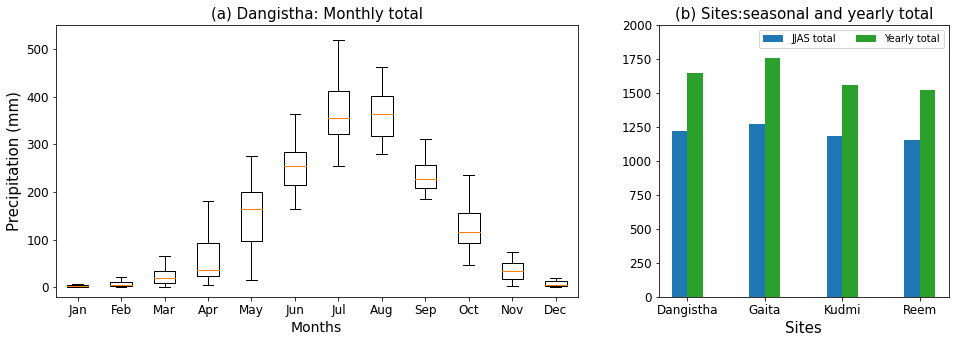

In [42]:

# Twelve months
monStr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
tAxis = np.arange(len(monStr))     
sitesStr = ['Dangistha', 'Gaita', 'Kudmi', 'Reem']
x = np.arange(len(sitesStr))                        # = Represents 3 products (Raw, LDay, L6hr)
width = 0.2    # = wdith of the bars
jjasTotToPlot = mswepJjasYrlyTot30YrsAvgSites[:, 0]
yrlyTotToPlot = mswepJjasYrlyTot30YrsAvgSites[:, 1]

import matplotlib.gridspec as gridspec
fontSize = 12
textFontVal = 15

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.8, 1])

axs = plt.subplot(gs[0,0])
axs.boxplot(mswepDanMonTotYrs, showfliers=False)
axs = axs.set(ylim=(-20, 550))
plt.xticks(range(1,13), monStr)

plt.ylabel('Precipitation (mm)', fontsize=textFontVal)
plt.xlabel(("Months"))
plt.title('(a) Dangistha: Monthly total', fontsize = 15 )

#+++++++++++++++++++++++++
ax12 = fig.add_subplot(gs[:1, 1])
ax12.bar(x, jjasTotToPlot, width=-1.*width, align='edge', label="JJAS total")
ax12.bar(x, yrlyTotToPlot, width=width, align='edge', color=list(plt.rcParams['axes.prop_cycle'])[2]['color'], label="Yearly total")

ax12.set_ylim([0, 2000])
ax12.set_xticks(x)
ax12.set_xticklabels(sitesStr, fontsize = 12)
plt.xlabel('Sites', fontsize=textFontVal)
plt.legend(ncol=2)

plt.title('(b) Sites:seasonal and yearly total', fontsize = 15)
plt.show()
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [43]:
#STOP

## Build a time series of monthly total precip over the last 30 years

### Dangistha

In [44]:
print(mswepDanMonTotYrs.shape)

(31, 12)


In [45]:
print(mswepDanMonTotYrs[:, 5:9])

[[286.5       457.5625    364.25      201.25     ]
 [232.4375    268.5625    296.9375    184.75     ]
 [253.6875    345.25      364.8125    259.125    ]
 [259.875     319.25      376.1875    211.6875   ]
 [362.5625    253.75      402.75      246.8125   ]
 [239.625     402.5       461.        300.125    ]
 [323.25      294.125     354.5       311.       ]
 [289.625     371.1875    401.9375    219.875    ]
 [345.5       302.9375    405.6875    247.625    ]
 [245.5       425.75      421.0625    221.3125   ]
 [214.3125    381.8125    333.0625    247.8125   ]
 [270.75      446.6875    308.1875    184.9375   ]
 [235.3125    350.375     280.8125    306.375    ]
 [215.        519.3125    294.        258.6875   ]
 [258.125     353.        334.8125    298.125    ]
 [342.25      420.5       352.375     212.375    ]
 [279.1875    322.8125    370.25      204.125    ]
 [247.        403.5625    378.3125    204.3125   ]
 [319.6875    400.875     398.        208.375    ]
 [294.0625    374.625     389.8

In [46]:
print(mswepDanMonTotYrs.shape)
mswepDanMonTotYrsClim = np.nanmean(mswepDanMonTotYrs, axis= 0)
print(mswepDanMonTotYrsClim.shape)
print(mswepDanMonTotYrsClim)

(31, 12)
(12,)
[  5.58644153   8.44027218  25.0171371   57.55367944 152.66658266
 254.98487903 371.05897177 359.11063508 237.08039315 129.18296371
  38.3203125   10.0063004 ]


In [47]:
mswepDanMonTotYrsRavel = np.ravel(mswepDanMonTotYrs)
print(mswepDanMonTotYrsRavel.shape)

(372,)


In [48]:
mswepDanMonTotYrsAnom = np.zeros((nYrsMswep, nMonsMswep))
print(mswepDanMonTotYrsAnom.shape)

(31, 12)


In [49]:
mswepDanMonTotYrsAnom = np.zeros((nYrsMswep, nMonsMswep))
print(mswepDanMonTotYrsAnom.shape)

(31, 12)


In [50]:

for yrId in range(nYrsMswep):
    
    for monId in range(nMonsMswep):    
        mswepDanMonTotYrsAnom[yrId, monId] = mswepDanMonTotYrs[yrId, monId] - mswepDanMonTotYrsClim[monId]   
    
print(mswepDanMonTotYrsAnom.shape)

(31, 12)


In [51]:
mswepDanMonTotYrsAnomRavel = np.ravel(mswepDanMonTotYrsAnom)
print(mswepDanMonTotYrsAnomRavel.shape)

(372,)


### Seasonal Total

In [52]:
mswepDanSeasonTotYrs = np.zeros((nYrsMswep, 2))
print(mswepDanSeasonTotYrs.shape)

(31, 2)


In [53]:
mswepDanSeasonTotAnomYrs = np.zeros((nYrsMswep, 2))
print(mswepDanSeasonTotAnomYrs.shape)

(31, 2)


### April May Total

In [54]:
print(mswepDanMonTotYrs.shape)

(31, 12)


In [55]:
mswepDanAprMayToSumYrs =mswepDanMonTotYrs[:, 3:5]
print(mswepDanAprMayToSumYrs.shape)

mswepDanAprMayTotYrs = np.nansum(mswepDanAprMayToSumYrs, axis = 1)
print(mswepDanAprMayTotYrs.shape)

(31, 2)
(31,)


In [56]:
mswepDanAprMayTotYrsAvg = np.nansum(mswepDanAprMayTotYrs)/nYrsMswep
print(mswepDanAprMayTotYrsAvg)

210.2202620967742


In [57]:
mswepDanAprMayTotYrsAnom = mswepDanAprMayTotYrs - mswepDanAprMayTotYrsAvg
print(mswepDanAprMayTotYrsAnom.shape)

(31,)


In [58]:
tAxis = [i for i in range(nYrsMswep)]
print(tAxis)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


### Panel Plot for AprMay

In [59]:

monSt = 4
monEnd = 5
monToPlot = 4   # Plotting Apr
timeList = []
for yr in range(yrStMswep,yrEndMswep+1): 
   
    for mon in range(monToPlot,monToPlot+1): 
        _,num_days = calendar.monthrange(yr,mon)      
        
        for day in range(1, 2):            
            hr = -3
            
            for hrCounter in range(1):           
                hr = hr + 3
                yMDH = datetime.datetime(yr,mon,day,hr)
                timeList.append(yMDH)
                
timeListDf = pd.DataFrame(timeList)
timeListDf.columns = ['t1']
timeListDf


,t1
0,1991-04-01
1,1992-04-01
2,1993-04-01
3,1994-04-01
4,1995-04-01
5,1996-04-01
6,1997-04-01
7,1998-04-01
8,1999-04-01
9,2000-04-01


In [60]:
yMD = timeListDf['t1'].dt.strftime('%Y').sort_values()

multiple = 5
multiple = np.ceil(multiple)
timeTickLebels = yMD[yMD.index % multiple == 0]
print(timeTickLebels)
timeTicks = yMD.index[yMD.index % multiple == 0]

0     1991
5     1996
10    2001
15    2006
20    2011
25    2016
30    2021
Name: t1, dtype: object


<ipython-input-61-35f0cf4c3050>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))
<ipython-input-61-35f0cf4c3050>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))


(-250.0, 250.0)

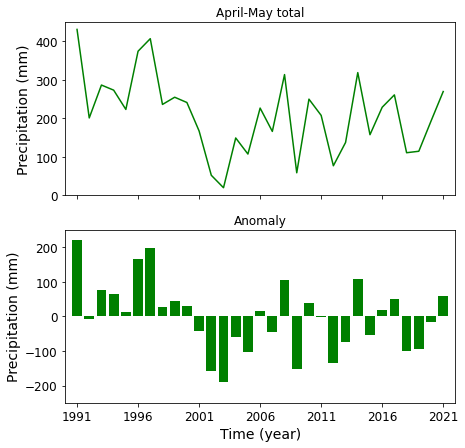

In [61]:
import matplotlib.gridspec as gridspec
fontSize = 14
textFontVal = 15
fig = plt.figure(figsize=(7, 7), )

plt.subplot(211)
plt.plot(tAxis, mswepDanAprMayTotYrs, label='', color='g')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))

plt.gca().set_xticks(timeTicks)
plt.gca().set_xticklabels('', minor=False)


plt.title('April-May total')
plt.xlabel('')

plt.ylabel('Precipitation (mm)')
plt.xlim([-1, nYrsMswep])
plt.ylim([0,450])
#+++++++++++++++++++++++++++++++++

plt.subplot(212)
plt.bar(tAxis,mswepDanAprMayTotYrsAnom, color='g')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))

plt.gca().set_xticks(timeTicks)
plt.gca().set_xticklabels(timeTickLebels, minor=False)

plt.title('Anomaly')
plt.xlabel('Time (year)')
plt.ylabel('Precipitation (mm)')
plt.xlim([-1, nYrsMswep])

plt.ylim([-250, 250])



### JJAS total

In [62]:
mswepDanJjasToSumYrs =mswepDanMonTotYrs[:, 5:10]
print(mswepDanJjasToSumYrs.shape)

mswepDanJjasTotYrs = np.nansum(mswepDanJjasToSumYrs, axis = 1)
print(mswepDanJjasTotYrs.shape)

(31, 5)
(31,)


In [63]:
mswepDanJjasTotYrsAvg = np.nansum(mswepDanJjasTotYrs)/nYrsMswep
print(mswepDanJjasTotYrsAvg)

1351.4178427419354


In [64]:
mswepDanJjasTotYrsAnom = mswepDanJjasTotYrs - mswepDanJjasTotYrsAvg
print(mswepDanJjasTotYrsAnom.shape)

(31,)


## Panel Diagram

<ipython-input-65-375487e645ca>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))
<ipython-input-65-375487e645ca>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))


(-250.0, 250.0)

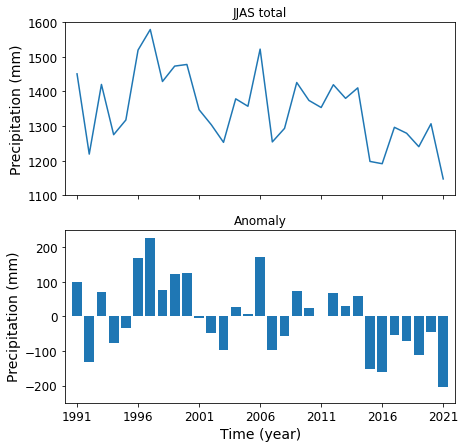

In [65]:
import matplotlib.gridspec as gridspec
fontSize = 14
textFontVal = 15
fig = plt.figure(figsize=(7, 7), )

plt.subplot(211)
plt.plot(tAxis, mswepDanJjasTotYrs, label='', color='tab:blue')

plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))

plt.gca().set_xticks(timeTicks)
plt.gca().set_xticklabels('', minor=False)


plt.title('JJAS total')
plt.xlabel('')

plt.ylabel('Precipitation (mm)')
plt.xlim([-1, nYrsMswep])

plt.ylim([1100, 1600])
#+++++++++++++++++++++++++++++++++

plt.subplot(212)
plt.bar(tAxis,mswepDanJjasTotYrsAnom, color='tab:blue')

plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(yMD))

plt.gca().set_xticks(timeTicks)
plt.gca().set_xticklabels(timeTickLebels, minor=False)

plt.title('Anomaly')
plt.xlabel('Time (year)')
plt.ylabel('Precipitation (mm)')
plt.xlim([-1, nYrsMswep])
plt.ylim([-250, 250])


In [66]:
STOP here ====================================

SyntaxError: invalid syntax (<ipython-input-66-2b59018e1e2e>, line 1)